In [5]:
from PIL import Image
import os

root = "../data/PetImages"
for subdir, _, files in os.walk(root):
    for file in files:
        path = os.path.join(subdir, file)
        try:
            with Image.open(path) as img:
                img.verify()  # Check integrity
        except Exception:
            print("Corrupted:", path)
            os.remove(path)

/home/amaury/repos/ucm-tfg/.venv/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

print(torch.__version__)

2.8.0+cpu


In [4]:
transform = transforms.Compose(
    [transforms.Resize((60,60)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

full_dataset = torchvision.datasets.ImageFolder("../data/PetImages", transform=transform)

dataset_len = len(full_dataset)
print(dataset_len)

train_size = int(0.95 * dataset_len)
test_size = dataset_len - train_size

trainset, testset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('Cat', 'Dog')

24998


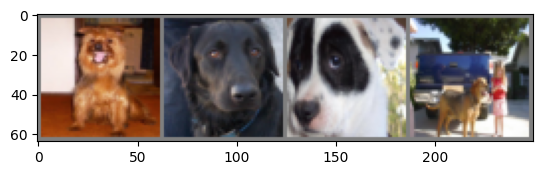

Dog   Dog   Dog   Dog  


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [9]:
import torch.nn as nn

img = images[0]

conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)

img = conv1(img)
print(img.shape)

img = pool(img)
print(img.shape)

img = conv2(img)
print(img.shape)

img = pool(img)
print(img.shape)

torch.Size([6, 56, 56])
torch.Size([6, 28, 28])
torch.Size([16, 24, 24])
torch.Size([16, 12, 12])


In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def class_image(self, path):

        with torch.no_grad():
            img = torchvision.io.read_image(path)
            img = transforms.ToPILImage()(img)
            raw_image = img
            img = transform(img)
            img = img.unsqueeze(0)

            output = net(img)
            probs = F.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)

            plt.imshow(raw_image)
            plt.xlabel(
                f"Predicted: {classes[predicted]} ({100*float(probs[0][predicted]):.2f}%)"
            )


net = Net()

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Finished Training")

[1,  2000] loss: 0.686


/home/amaury/repos/ucm-tfg/.venv/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[1,  4000] loss: 0.652
[2,  2000] loss: 0.593


/home/amaury/repos/ucm-tfg/.venv/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[2,  4000] loss: 0.566
Finished Training


In [13]:
PATH = "./cat_dog.pth"
torch.save(net, PATH)

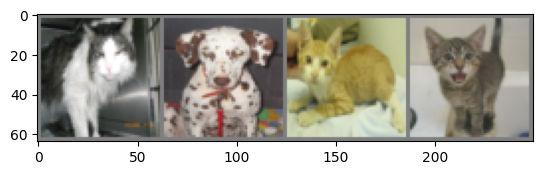

GroundTruth:  Cat   Dog   Cat   Cat  


In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

In [6]:
PATH = "./cat_dog.pth"

net = torch.load(PATH, weights_only=False)

In [16]:
outputs = net(images)

probs = F.softmax(outputs, dim=1)
print(probs)


tensor([[0.8064, 0.1936],
        [0.0058, 0.9942],
        [0.8388, 0.1612],
        [0.6154, 0.3846]], grad_fn=<SoftmaxBackward0>)


In [17]:
_, predicted = torch.max(outputs, 1)

print(predicted)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

tensor([0, 1, 0, 0])
Predicted:  Cat   Dog   Cat   Cat  


In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the {total} test images: {100 * correct // total} %")

Accuracy of the network on the 1250 test images: 72 %


In [19]:
def class_image(path):

    with torch.no_grad():

        img = torchvision.io.read_image(path)

        img = transforms.ToPILImage()(img)

        raw_image = img

        img = transform(img)

        img = img.unsqueeze(0)

        output = net(img)
        probs = F.softmax(output, dim=1)
        _, predicted = torch.max(output, 1)

        plt.imshow(raw_image)
        plt.xlabel(
            f"Predicted: {classes[predicted]} ({100*float(probs[0][predicted]):.2f}%)"
        )

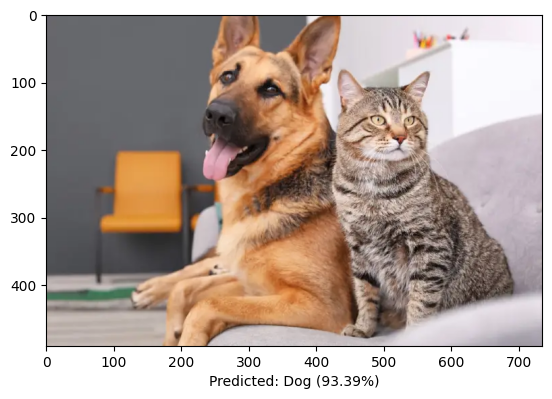

In [18]:
import matplotlib.pyplot as plt

net.class_image("catanddog.webp")